In [3]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [4]:
sns.set_palette('Set2')
%matplotlib inline

# Get data

#### The data of Bitcoin/USD, we use joint URL in order to analyze the effect Ethereum later.

In [5]:
# API of Cryptographic currency in json format
url = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(url + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.head(1)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2013-05-23,126.3,126.93,123.0,123.8,22118.25,2772751.89


In [6]:
hist.tail(1)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2018-11-13,6346.28,6381.17,6315.58,6375.08,12096.19,77075957.6


#### Now set close price as target data, and later we will add price gap into model

# Split training and test dataset

80% is used for training, 20% is used for testing.

In [7]:
def train_test_split(df, test_size):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

# Build LSTM Model

#### Normalization

As the model does not ought to predict future price, but future change percentage.

In [9]:
# The other way: scaler = scaler = StandardScaler()
# 但是模型的目的不是变成正态分布，而是将第一天设为0，计算的变化值，然后再根据基准值，
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    return df / df.iloc[0] - 1

#### smoothed data for average-n-days

In [10]:
def extract_window_data(df, window_len, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [16]:
target_col = 'close'

In [17]:
def prepare_data(df, target_col,window_len, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
#     y_train = train_data[target_col][window_len:].values
#     y_test = test_data[target_col][window_len:].values
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        # 后n天比前n天的比值,变化的百分比
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

#### 1 layer LSTM model

In [18]:
# sigmoid is not as good as linear, as this data is one dimension and linear structure.
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()
    print('input_data.shape'+str(input_data.shape))
    # LSTM: input data should be 3D tensor with shape (nb_samples, timesteps, input_dim).
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [19]:
np.random.seed(42)

# data params
window_len = 90
test_size = 0.15
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

# train, test = train_test_split(hist, test_size=0.2)

train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [20]:
X_train.shape

(1611, 90, 6)

In [21]:
# pandas dataframe
test.shape

(300, 6)

In [22]:
# 经过标准化的
X_test.shape

(210, 90, 6)

In [23]:
from keras.callbacks import EarlyStopping

# 两次loss连续上升就会停止
early_stopping = EarlyStopping(monitor='loss', patience=2)

model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    verbose=1, shuffle=True,callbacks=[early_stopping])

input_data.shape(1611, 90, 6)
Epoch 1/50
1611/1611 [==============================] - 33s 20ms/step - loss: 0.3293
Epoch 2/50
1611/1611 [==============================] - 32s 20ms/step - loss: 0.1799
Epoch 3/50
1611/1611 [==============================] - 34s 21ms/step - loss: 0.1416
Epoch 4/50
1611/1611 [==============================] - 34s 21ms/step - loss: 0.1348
Epoch 5/50
1611/1611 [==============================] - 35s 22ms/step - loss: 0.1203
Epoch 6/50
1611/1611 [==============================] - 33s 21ms/step - loss: 0.1134
Epoch 7/50
1611/1611 [==============================] - 32s 20ms/step - loss: 0.1225
Epoch 8/50
1611/1611 [==============================] - 31s 19ms/step - loss: 0.1161


# Multiple time sequence Prediction

In [553]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        # 每prediction_len一个区间
        curr_frame = data[i*prediction_len]
        predicted = []
        # 在每个prediction_len的区间内
        for j in range(prediction_len):
            # 新加一个维度
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            # 每次移动一个位置，加入新的预测值进行下一次预测
            curr_frame = curr_frame[1:]
            # 必须是1，不然：list index out of range，因为上一行代码推进了一个数据点
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    print('prediction_seqs shape'+ str(np.array(prediction_seqs).shape))
    return prediction_seqs

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        # 如果是prediction_len的倍数，就空一个点
        padding = [None for p in range(i * prediction_len)]
#         plt.plot(padding + data,label='prediction')
        plt.plot(padding + data)
        plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    plt.xticks(rotation=45)
    plt.show()

In [554]:
type(X_test)

numpy.ndarray

In [555]:
X_test.shape

(210, 90, 6)

In [556]:
# predictions 
y_test.shape

(210,)

prediction_seqs shape(30, 7)
predictions shape(30, 7)


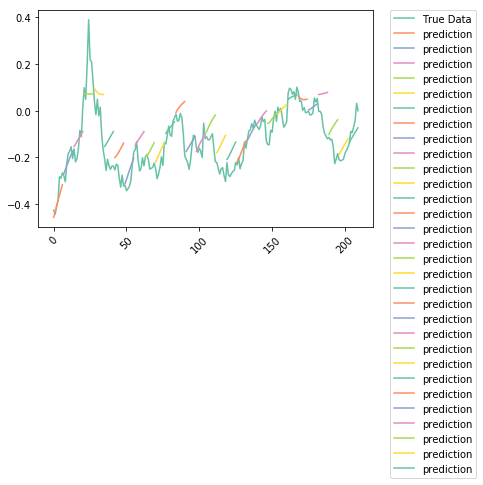

In [557]:
predictions = predict_sequences_multiple(model, X_test, 90, 7)
print ('predictions shape'+str(np.array(predictions).shape))
plot_results_multiple(predictions, y_test, 7)

In [558]:
predictions = np.array(predictions)
predictions[0]

array([-0.4579693 , -0.43445778, -0.4093933 , -0.3852365 , -0.36194995,
       -0.3396275 , -0.31829697], dtype=float32)

In [559]:
# for i in range(5):
#     print (i) # 0-4

### 把标准化的数据还原为正常值

unnorm_pre = []
def predict_unnorm_data(data,prediction_len):
    for i in range(int(len(data)/prediction_len)):
        # 每prediction_len一个区间
        predicted_line = []
        p = test[target_col][i*prediction_len]
        for j in range(prediction_len):
            # 每一天都是基于上一天进行变化的
            p = p*(1+predictions[i][j])
            predicted_line.append(p)
        unnorm_pre.append(predicted_line)
    return unnorm_pre       

In [ ]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
# 直接用 inverted = scaler.inverse_transform(array)
unnorm_pre = []
def predict_unnorm_data(data,prediction_len):
    for i in range(int(len(data)/prediction_len)):
        # 每prediction_len一个区间
        predicted_line = []
        for j in range(prediction_len):
            p = test[target_col][i*prediction_len]
            # 每一天都是基于第一天进行变化的
            p = p*(1+predictions[i][j])
            predicted_line.append(p)
        unnorm_pre.append(predicted_line)
    return unnorm_pre 

In [561]:
y_test = test[target_col][window_len:].values
predict_unnorm_data = predict_unnorm_data(y_test,prediction_len=7)

### 方法1: 把预测值flatten，加上同样的索引，再画图。虽然解决了时间index的绘制问题，但是却因为没有设padding，但其实并不影响

In [562]:
# 真实值
y_true = test[target_col][window_len:]
# 预测值flatten
predict_unnorm_data = np.array(predict_unnorm_data).reshape(-1)
predict_unnorm_data = pd.DataFrame(predict_unnorm_data)
# 统一矩阵大小
n_shape = len(predict_unnorm_data)
y_true = pd.DataFrame(y_true)
y_true = y_true[:n_shape]
y_true.shape
# 统一时间index
predict_unnorm_data['time'] = y_true.index
predict_unnorm_data.columns = ['y_true', 'time']
predict_unnorm_data = predict_unnorm_data.set_index('time')
predict_unnorm_data.shape

(210, 1)

In [563]:
def plot(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.xticks(rotation=45)
    plt.plot(predicted_data, label='Prediction')
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    plt.show()

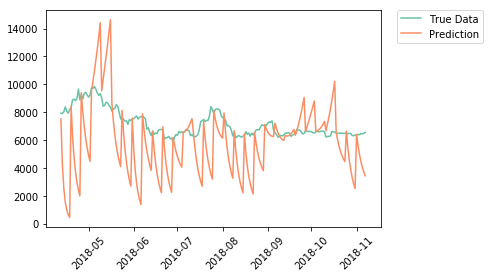

In [564]:
plot(predict_unnorm_data,y_true)

In [565]:
### 计算RMSE，并将数据存到csv
from datetime import datetime,timedelta
import math
from sklearn.metrics import mean_squared_error

# truncate预测日期
begin_date = datetime(year=2018, month=10, day=18)
end_date = begin_date + timedelta(days=6)
# 求指定预测日期之间的RMSR
mse = mean_squared_error(y_true[begin_date:end_date], predict_unnorm_data[begin_date:end_date])
rmse = math.sqrt(mse)
print(rmse)

1362.2878511198817


In [536]:
# 合并dataframe
file = pd.concat([y_true, predict_unnorm_data],axis=1)
file.columns = ['y_true', 'predict_unnorm_data']
# new column 'rmse'
file['rmse'] = rmse
file[begin_date:end_date]

,y_true,predict_unnorm_data,rmse
time,,,
2018-10-18,6488.72,7368.099158,865.481638
2018-10-19,6469.28,7368.099158,865.481638
2018-10-20,6490.56,7368.099158,865.481638
2018-10-21,6509.87,7368.099158,865.481638
2018-10-22,6483.23,7368.099158,865.481638
2018-10-23,6470.22,7301.661766,865.481638
2018-10-24,6476.25,7301.661766,865.481638


### 方法2: 将时间index循环放到predict_unnorm_data里，再画图，就可以加入padding进行空格

In [ ]:
predict_unnorm_data = np.array(predict_unnorm_data)
predict_unnorm_data = pd.DataFrame(predict_unnorm_data)

# 真实值
y_true = test[target_col][window_len:]
y_true.index[0]

def set_index(data,prediction_len):
    time_index = []
    n = len(predict_unnorm_data)
    for i in range(n):
        time = y_true.index[prediction_len*i]
        print('time is '+str(time))
        time_index.append(time)
    return time_index

time_index = set_index(predict_unnorm_data,7)

predict_unnorm_data['time'] = time_index
predict_unnorm_data = predict_unnorm_data.set_index('time')

plot_results_multiple(predict_unnorm_data, y_true, 7)

### 以上，已经实现了用6维输入，并用预测值进行预测。